In [1]:
#importing libraries

import pandas as pd
import math
import numpy as np
from datetime import datetime,date
import pytz
import matplotlib.pyplot as plt
from IPython.core.ultratb import VerboseTB
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
VerboseTB._tb_highlight = "bg:#039dfc"
import scipy.optimize as spo
import time
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import plot_model
import requests
import json


2024-10-27 17:36:42.380594: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# class for technical indicators. I receives a dataframe and returns, for each method, 
# a new column with the values calculated based on an input column.

class TechnicalIndicators():
    def __init__(self, data_frame):
        self.df = data_frame.copy()

    # calculation of the return of column after an interval of n days
    def momentum(self, column, n, offset=0):
        if f'{column}_momentum_{n}*' not in self.df.columns:
            close_prices = self.df.loc[offset:,column]
            momentum = close_prices / close_prices.shift(n) - 1
            momentum[0:n]=1
            self.df[f'{column}_momentum_{n}'] = momentum
            
        return self.df[f'{column}_momentum_{n}']
    
    # moving average of column i of returns through n days
    def simple_movement_average(self, column, n, offset=0):
        if f'{column}_sma_{n}*' not in self.df.columns:
            window_mean = self.df.loc[offset:,column].rolling(n).mean()
            window_mean[0:n]=  window_mean[n]
            self.df[f'{column}_sma_{n}'] = self.df[column] / window_mean - 1
        return self.df[f'{column}_sma_{n}']
    
    # calculate upper and lower 2*std_deviation lines
    def _get_bollinger_bands(self, rm, rstd):
        upper_band = rm + rstd * 2
        lower_band = rm - rstd * 2
        return upper_band, lower_band
    
    # moving average and +/- 2*std_deviation lines
    def bollinger_bands(self, column, window_size=20, offset=0):
        if f'{column}_upper_band*' not in self.df.columns:
            self.df[f'{column}_mm20'] = self.df.loc[offset:,column].rolling(window_size).mean()
            self.df.loc[0:window_size,f'{column}_mm20'] =  self.df.loc[window_size,f'{column}_mm20']
            rstd = self.df.loc[offset:,column].rolling(window_size).std()
            rstd.iloc[0:window_size] = rstd.iloc[window_size]
            self.df[f'{column}_upper_band'], self.df[f'{column}_lower_band'] = self._get_bollinger_bands(self.df[f'{column}_mm20'], rstd)
        return self.df[[column, f'{column}_mm20', f'{column}_upper_band', f'{column}_lower_band']]
    
    # daily and cumulative returns of column
    def add_daily_return(self,column):
        self.df[f'{column}_daily_return'] = (self.df[column] / self.df[column].shift(1)) - 1
        self.df.loc[0,f'{column}_daily_return'] = 0
        self.df[f'{column}_cumulative_return'] = (self.df[column] / self.df[column].values[0]) - 1
        self.df.loc[0,f'{column}_cumulative_return'] = 0
        
    # log return after n days of column
    def log_returns(self,column,n):
        self.df[f'{column}_log_return_{n}'] = np.log((self.df[column] / self.df[column].shift(n)))
        self.df.loc[0:n,f'{column}_log_return_{n}'] = self.df.loc[n,f'{column}_log_return_{n}']
        return self.df[f'{column}_log_return_{n}']
    
    

In [3]:
# get stock (ticker) data from yahoo finance from start to end dates
class stock_dataframe():
    def __init__(self,ticker,start,end):
        self.ticker = ticker
        self.start = start 
        self.end = end

#    def conv_df(resp):
#        j = resp.json()
#        data = [j['chart']['result'][0]['timestamp']] + list(j['chart']['result'][0]['indicators']['quote'][0].values() + list(j['chart']['result'][0]['indicators']['adjclose'][0].values())
#        df = pd.DataFrame(
#        {'timestamp': data[0], 'close': data[1], 'open': data[2], 'high': data[3], 'low': data[4], 'volume': data[5], 'adjclose': data[6]})
#        df['time'] = pd.to_datetime(df['timestamp'], unit='s')
#        df['date'] = df['time'].apply(lambda x: x.strftime('%Y-%m-%d'))
#        return df
        
    def get_stock_data(self):
        start_date = date.fromisoformat(self.start)
        end_date = date.fromisoformat(self.end)
        start_stamp = int(datetime(start_date.year, start_date.month, start_date.day, tzinfo=pytz.UTC).timestamp())
        end_stamp = int(datetime(end_date.year, end_date.month, end_date.day, tzinfo=pytz.UTC).timestamp())
        print(start_date, end_date)
        #self.start_stamp = datetime.timestamp(self.start_date)
        #self.end_stamp = datetime.timestamp(self.end_date)
        print(start_stamp,end_stamp)
        url = "https://query2.finance.yahoo.com/v8/finance/chart/%s?period1=%i&period2=%i&interval=1d&events=history&includeAdjustedclose=true" % (self.ticker,start_stamp,end_stamp)
        print(url)
        response = requests.get(url,headers = {'User-agent': 'Request %s' % self.ticker})
        data = response.json()
        result = data["chart"]["result"][0]
        stock = pd.DataFrame(result["indicators"]["quote"][0])
        stock['adjclose'] = result["indicators"]["adjclose"][0]["adjclose"]
        stock['date'] = pd.to_datetime(result["timestamp"], unit='s')
        self.stock = stock
        #print(json.dumps(data, indent=4))
        #data = json.loads(response.text)
        #self.stock = pd.read_csv(url)
       # self.stock = pd.json_normalize(response.json())
        print(self.stock)
        self.stock["relhigh"] = self.stock["high"]/self.stock["adjclose"]
        self.stock["rellow"] = self.stock["low"]/self.stock["adjclose"]
        self.stock["relopen"] = self.stock["open"]/self.stock["adjclose"]
        return self.stock
    
    # Convert Date to Day, Month and Year columns.
    def Date_Convert(self):
        self.stock['date'] = pd.to_datetime(self.stock['date'])
        self.stock['year'] = self.stock['date'].dt.year
        self.stock['month'] = self.stock['date'].dt.month
        self.stock['day'] = self.stock['date'].dt.day
        
    # define Scaler
    def Standard_Scaler(self):
        self.scaler = StandardScaler()
    
    def Min_Max_Scaler(self):
        self.scaler = MinMaxScaler()
        
    # Calculate technical indicators    
    def Get_Technical_Indicators(self,price):
        TI = TechnicalIndicators(self.stock)
        TI.momentum(price,15)
        TI.simple_movement_average(price,15)
        TI.bollinger_bands(price,15)
        TI.add_daily_return(price)
        TI.log_returns(price,1)
        self.stock = TI.df
        return self.stock
        
    # Perform Chosen normalization    
    def Normalize(self):
        # Define the column to leave unchanged
        unchanged_column = 'date'

        # Create a subset of columns excluding the unchanged column
        columns_to_scale = [col for col in self.stock.columns if col != unchanged_column]

        # Copy the DataFrame
        stock_normalized = self.stock.copy()

        # Apply StandardScaler to the subset of columns
        stock_normalized[columns_to_scale] = self.scaler.fit_transform(self.stock[columns_to_scale])

        print(stock_normalized)

        # Concatenate the normalized subset with the unchanged column
        stock_normalized = pd.concat([stock_normalized[unchanged_column], stock_normalized[columns_to_scale]], axis=1)

        # rename adjusted close to avoid spaces 

        return stock_normalized



In [4]:
# Merge stock dataframes for all options in a single dataframe 
def merge_stocks(options):
    df = pd.DataFrame()
    for stock in options:
        print("stock =",stock)
        # define stock data class
        stock_data = stock_dataframe(stock,"2021-12-01","2021-12-31")
        
        # read data
        stock_data.get_stock_data()
        
        # convert Date to Day, Month and Year columns
        stock_data.Date_Convert()
        
        # Calculate additional variables
        stock_data.Get_Technical_Indicators("adjclose") 
        
        print("stock_data.stock = ",stock_data.stock)
        # Apply normalization
        date_columns = ["date","year","month","day"]
        df_stock = (stock_data.stock-stock_data.stock.mean())/stock_data.stock.std()
        # Identify columns with identical values across all DataFrames
        identical_columns = []
        distinct_columns = []

        # merge with other options 
        for col in df_stock.columns:
            if (col in df and col in df_stock):
                if df[col].equals(df_stock[col]): identical_columns.append(col)
            else: 
                if col not in date_columns: df_stock.rename(columns={col: stock + '_' + col}, inplace=True)
        # Identify columns with distinct values across the DataFrames
        distinct_columns = [col for col in df_stock.columns if col not in identical_columns]

        df = pd.concat([df,df_stock[distinct_columns]],axis=1)
    print(df)
    return df

In [5]:
# Class for calculating option weights for an optimal portfolio for each day 
class PortfolioOptimization:
    def __init__(self, data_frame, options):
        self.df = data_frame.copy()
        self.options = options.copy()
        self.init_weights()

     # initialize weights        
    def init_weights(self):
        for stock in self.options:
            if f'{stock}_weight' not in self.df.columns:
                self.df[f"{stock}_weight"] = 1 / len(self.options)

    # constraints for optimization. Might not be needed in case W_i/sum(W_i) is used             
    def _constraints(self, weights):
        return np.sum(weights) - 1
    
    # Sharpe ration calculation of the full portfolio. Currently using constant as risk free return
    def sharpe_ratio(self, weights, returns, std, rfree):
        norm_weights = weights / np.sum(weights)
        total_return = np.sum(norm_weights * returns)
        portfolio_stddev = np.sum(norm_weights*norm_weights*std*std)
        return (total_return - rfree) / portfolio_stddev
    
    # Minimize target funcion, maximizing the Sharpe ratio
    def target_function(self, weights, returns, stddev, rfree):
        return -self.sharpe_ratio(weights, returns, stddev, rfree)

    # weight optimization using scikit.optmize.minimize. Might not be the best choice, still can test alternatives. Need to check optimized values 
    def optimize_weights(self, weights, returns, stddev, rfree):
        constraints = {'type': 'eq', 'fun': self._constraints}
        bounds = [(0, 1) for _ in range(len(weights))]

        result = spo.minimize(
            self.target_function,
            weights,
            args=(returns, stddev, rfree),
            constraints=constraints,
            bounds=bounds,
            method='SLSQP'  # Sequential Least Squares Programming optimizer
        )
        
        if not result.success:
            raise ValueError(f"Optimization failed: {result.message}")

        return result.x
    
    # Apply optimization for each row. 
    def get_optimal_weights(self, rfree):
        weight_columns = [col for col in self.df.columns if col.endswith('_weight')]
        return_columns = [col.replace('_weight', '_adjclose_log_return_1') for col in weight_columns]
        stddev_columns = [self.df[col].std() for col in return_columns]

        def apply_optimization(row):
            weights = row[weight_columns].values
            returns = row[return_columns].values
            optimal_weights = self.optimize_weights(weights, returns, stddev_columns, rfree)
            return pd.Series(optimal_weights, index=weight_columns)

        # df.apply was tricky to use with a function with many parameters, to be applied in many columns. This was the workaround which worked  
        self.df[weight_columns] = self.df.apply(apply_optimization, axis=1)
        return self.df[weight_columns]

In [6]:
# class for calculating evaluation metrics of the model
class Metrics():
    def __init__(self, in_df, pred_df, targets):
        common_indices = in_df.index.intersection(pred_df.index)
        common_indices = common_indices[:-1]
        self.in_df = in_df.loc[common_indices].copy()
        self.pred_df = pred_df.loc[common_indices].copy()
        self.targets = targets.copy()
        self.out = pd.DataFrame()
        self.mse = {}

    # pull = (predicted - data)/std_dev    
    def pull(self):
        for column in self.targets:
            # Ensure both return Series
            in_series = self.in_df[column].squeeze()
            pred_series = self.pred_df[column].squeeze()
            diff = pred_series - in_series
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            pull = diff/math.sqrt(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_Pull'] = pull
        return self.out.filter(like='Pull')

    # chisq = (predicted - data)**2/std_dec**2
    def chisq(self):
        for column in self.targets:
            in_series = self.in_df[column].squeeze()
            pred_series = self.pred_df[column].squeeze()
            diff = pred_series - in_series
            in_std = self.in_df[column].std()
            pred_std = self.in_df[column].std()
            chisq = diff*diff/(pow(in_std,2) + pow(pred_std,2))
            self.out[f'{column}_ChiSq'] = chisq
        return self.out.filter(like='ChiSq')
    
    # mse = sum(chisq)/n_rows for every row
    def get_mse(self):
        for column in self.targets:
            if f'{column}_ChiSq' not in self.out.columns:
                self.chisq()
            self.mse[column] = self.out[f'{column}_ChiSq'].sum()/len(self.out[f'{column}_ChiSq'])
        return self.mse

In [7]:
class data_prep(): 
    def __init__(
        self, 
        df, 
        features, 
        targets, 
        train_fraction=0.5, 
        validation_fraction=0.25, 
        rwin=7, 
        offset=1, 
    ):
        self.df = df.copy()
        self.features = features.copy()
        self.targets = targets.copy()
        self.train_fraction = train_fraction
        self.validation_fraction = validation_fraction
        self.rwin = rwin
        self.offset = offset

    def calculate_metrics(self):
        Met = Metrics(self.Train_Dat[self.targets],self.Train_Pred[self.targets],self.targets)
        self.train_pull  = M_Train.pull()
        self.train_chisq = M_Train.chisq()
        self.train_mse   = M_Train.get_mse()

        return self
    
    def create_sequences(self):
        self.sequences = []
        self.featureval = self.df[self.features].values
        for start_idx in range(len(self.featureval) - rwin + 1):
            end_idx = start_idx + rwin
            sequence = self.featureval[start_idx:end_idx]
            self.sequences.append(sequence)
            
        return self.sequences

    def create_targetval(self):
        self.targetval = self.df[self.targets].values
        return self.targetval
    
    def split_data(self):
        train_split = int((len(self.targetval) - self.rwin)*self.train_fraction)
        validation_split = int((len(self.targetval) - self.rwin)*self.validation_fraction)
        train_sequences = self.sequences[:train_split]
        validation_sequences = self.sequences[train_split:train_split + validation_split]
        test_sequences = self.sequences[train_split + validation_split:]
        train_targets = self.targetval[rwin:rwin + train_split]
        validation_targets = self.targetval[rwin + train_split:rwin + train_split + validation_split]
        test_targets = self.targetval[rwin + train_split + validation_split:]
        print("len(self.sequences) = ", len(self.sequences))
        print("len(self.targetval) = ", len(self.targetval))
        print("self.rwin = ", self.rwin)
        print("self.train_fraction = ", self.train_fraction)
        print("self.validation_fraction = ", self.validation_fraction)
        print("train_split = ", train_split)
        print("valdation_split = ", validation_split)
        return train_sequences, validation_sequences, test_sequences, train_targets, validation_targets, test_targets
        

In [8]:
options = ["ITUB4.SA",
           "VALE3.SA"
          ] 
prices = ["VALE3.SA_adjclose_log_return_1","ITUB4.SA_adjclose_log_return_1"]
features = ["VALE3.SA_adjclose_log_return_1","VALE3.SA_relhigh","VALE3.SA_rellow","ITUB4.SA_adjclose_log_return_1","ITUB4.SA_relhigh","ITUB4.SA_rellow"]
targets = ["VALE3.SA_adjclose_log_return_1","ITUB4.SA_adjclose_log_return_1"]


In [9]:
df = merge_stocks(options)
df.index.start

print("df = ",df)

port = PortfolioOptimization(df,options)
port.init_weights()
weights = port.get_optimal_weights(0.00)
print("weights = ", weights)
print("port.df = ",port.df)

df = port.df

stock = ITUB4.SA
2021-12-01 2021-12-31
1638316800 1640908800
https://query2.finance.yahoo.com/v8/finance/chart/ITUB4.SA?period1=1638316800&period2=1640908800&interval=1d&events=history&includeAdjustedclose=true
         open    volume        low       high      close   adjclose  \
0   22.559999  23849300  22.200001  22.920000  22.219999  19.202461   
1   22.440001  31354000  22.340000  23.160000  23.059999  19.928392   
2   22.969999  35504500  22.820000  23.600000  22.980000  19.859253   
3   23.100000  37250600  23.000000  23.770000  23.250000  20.092585   
4   23.620001  30697500  22.799999  23.639999  22.959999  19.841969   
5   23.090000  37934300  22.450001  23.139999  22.740000  19.651846   
6   22.780001  27963900  21.950001  22.790001  22.129999  19.124685   
7   22.280001  20695800  21.870001  22.430000  22.160000  19.150614   
8   22.200001  48532100  21.570000  22.420000  21.570000  18.640734   
9   21.760000  31477500  21.680000  22.160000  21.780001  18.822218   
10  21.9

/var/folders/k_/w3z0rb550bq5y149v61zw1lw0000gn/T/ipykernel_86698/2957867812.py:21: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_stock = (stock_data.stock-stock_data.stock.mean())/stock_data.stock.std()


        close       open       high        low    volume   adjclose  \
0   70.230003  71.300003  71.949997  69.970001  28194700  55.654152   
1   73.489998  70.970001  73.559998  70.110001  24888400  58.237560   
2   71.870003  73.089996  74.339996  71.000000  34451500  56.953781   
3   75.769997  72.870003  75.989998  71.959999  28848800  60.044350   
4   76.330002  78.279999  79.809998  76.099998  37125100  60.488132   
5   75.760002  76.989998  76.989998  74.980003  24281000  60.036438   
6   75.180000  74.889999  75.949997  74.449997  16925200  59.576805   
7   75.650002  75.500000  76.199997  74.839996  16827100  59.949272   
8   77.860001  77.500000  78.730003  77.389999  31699100  61.700581   
9   77.849998  78.519997  78.889999  77.230003  21063500  61.692661   
10  77.410004  78.080002  78.180000  76.199997  22112200  61.343990   
11  80.440002  79.000000  80.459999  78.459999  30125700  63.745129   
12  79.169998  79.900002  80.669998  79.070000  38744500  62.738701   
13  78

/var/folders/k_/w3z0rb550bq5y149v61zw1lw0000gn/T/ipykernel_86698/2957867812.py:21: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  df_stock = (stock_data.stock-stock_data.stock.mean())/stock_data.stock.std()


In [10]:
rwin = 7
dp = data_prep(df,features, targets, rwin =rwin)
sequences = dp.create_sequences()
targetvals = dp.create_targetval()

train_sequences, validation_sequences, test_sequences, train_targets, validation_targets, test_targets = dp.split_data()
print("train_sequences = ", train_sequences)
print("validation_sequences = ", validation_sequences)
print("test_sequences = ", test_sequences)
print("train_targets = ", train_targets)
print("validation_targets = ", validation_targets)
print("test_targets = ", test_targets)

len(self.sequences) =  15
len(self.targetval) =  21
self.rwin =  7
self.train_fraction =  0.5
self.validation_fraction =  0.25
train_split =  7
valdation_split =  3
train_sequences =  [array([[1.6494877565596018, 1.0468047025266556, 0.7578763160963865,
        2.1943334973512214, 1.407454302022832, 1.1488779362823294],
       [1.6494877565596018, -1.0431350602862526, -2.550248635751671,
        2.1943334973512214, -1.2215526981213432, -3.190659558095612],
       [-1.2691607081477683, 1.9237302110998988, 0.10055331060196025,
        -0.14036461491752897, 0.9697288778449769, 0.28125598762730203],
       [1.9716808845731042, -0.8698939199531622, -2.8859043340159665,
        0.7315685590882633, 0.5231915597023095, -0.26113363297970404],
       [0.009950208317080902, 2.92028225168249, 0.8117585045986074,
        -0.66250917798805, 1.2248906322463593, 0.2803883866244013],
       [-0.6309926388649499, 0.3138068241126625, 0.24209789681413127,
        -0.494323117606983, 0.06104692098446153, -0

In [11]:
# 3. Define a simple LSTM model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(rwin, len(features))))
model.add(Dense(len(targets)))  # Output layer for regression
model.compile(optimizer='adam', loss='mse')

2024-10-27 17:37:15.069218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-27 17:37:15.072053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-27 17:37:15.073372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [12]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]
train_sequences = np.asarray(train_sequences).astype('float32')
validation_sequences = np.asarray(validation_sequences).astype('float32')
test_sequences = np.asarray(test_sequences).astype('float32')
train_targets = np.asarray(train_targets).astype('float32')
validation_targets = np.asarray(validation_targets).astype('float32')
test_targets = np.asarray(test_targets).astype('float32')

(None, 7, 6) <dtype: 'float32'>
(None, 2) <dtype: 'float32'>
lstm (None, 7, 6) float32
dense (None, 50) float32


In [13]:
history = model.fit(train_sequences,train_targets,epochs=100, batch_size=1, verbose=0)

2024-10-27 17:37:15.634118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-27 17:37:15.637032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-27 17:37:15.639152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [14]:
validation_pred = model.predict(validation_sequences)

1/1 [==============================] - 0s 398ms/step


2024-10-27 17:37:18.465718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-10-27 17:37:18.466704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-10-27 17:37:18.468605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [15]:
print(validation_pred)
print(validation_targets)

[[-0.50579566 -0.74926925]
 [-0.8305704  -0.7087966 ]
 [-0.5376645  -1.0932548 ]]
[[ 0.81276184  0.14122047]
 [-0.5337628   0.27677175]
 [-0.7252827   0.3568779 ]]


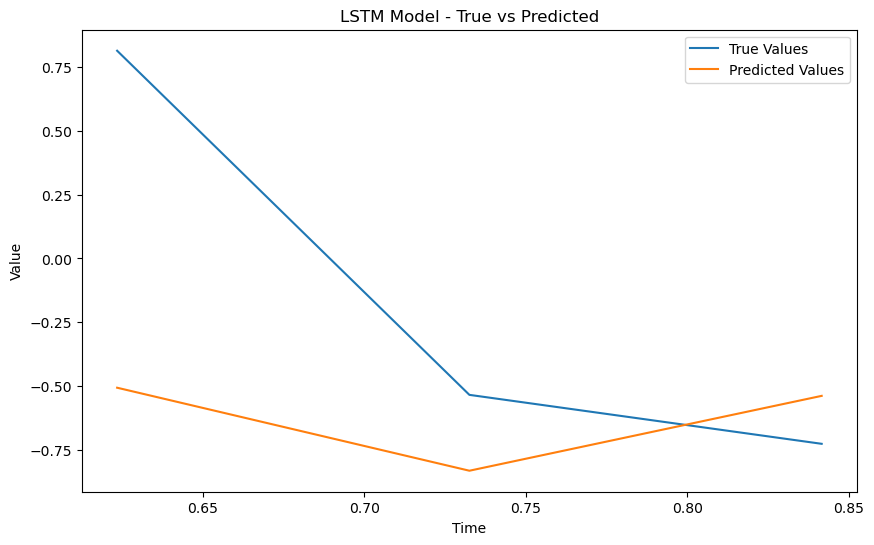

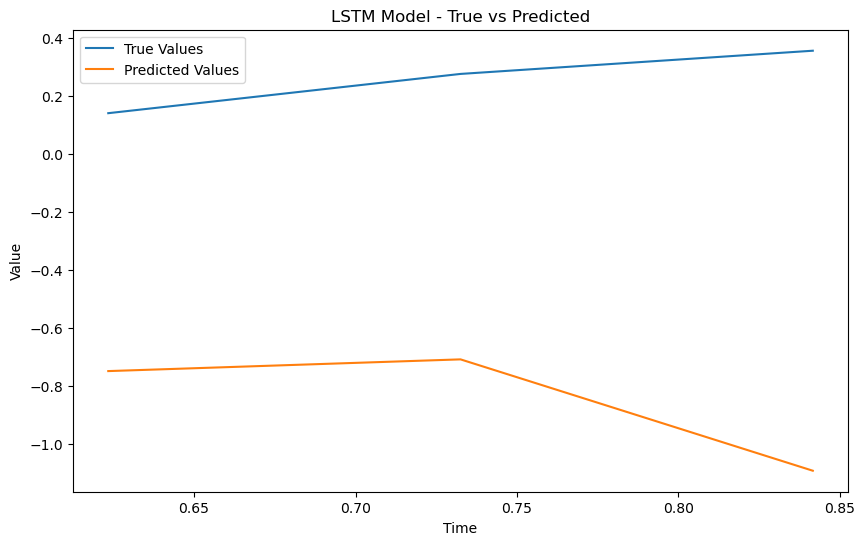

In [16]:
split_validation_targets = np.array_split(validation_targets,len(validation_pred[0]),axis=1)
split_validation_pred = np.array_split(validation_pred,len(validation_pred[0]),axis=1)
for i in range(len(validation_pred[0])):
    plt.figure(figsize=(10, 6))
    plt.plot(df['date'][rwin+len(train_targets):rwin+len(train_targets)+len(validation_targets)], split_validation_targets[i], label='True Values')
    plt.plot(df['date'][rwin+len(train_targets):rwin+len(train_targets)+len(validation_targets)], split_validation_pred[i], label='Predicted Values')
    plt.title('LSTM Model - True vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [18]:
plot_model(model, to_file="Plots/model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
# MLP regressor model
class model():
    def __init__(self, 
             df, 
             features, 
             targets, 
             train_fraction=0.5, 
             validation_fraction=0.25, 
             rwin=90, 
             offset=1, 
             hidden_layers=[20,20,20], 
             learning_rate=0.0001, 
             tolerance = 0.0001):
        self.df = df.copy()
        self.features = features.copy()
        self.targets = targets.copy()
        self.train_fraction = train_fraction
        self.validation_fraction = validation_fraction
        self.rwin = rwin
        self.offset = offset
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.tolerance = tolerance
    
    # copy all parameters, used to update model during validation
    def set_pars(self,rwin,learning_rate,tolerance,hidden_layers):
        self.rwin = rwin
        self.hidden_layers = hidden_layers
        self.learning_rate = learning_rate
        self.tolerance = tolerance

    # split data in training, validation and test sets
    def split_data(self):
        Train_End = round(self.train_fraction*len(self.df))
        Validation_End = round(self.train_fraction*len(self.df)) + round(self.validation_fraction*len(self.df))
        self.Train_Data = self.df[:Train_End]
        self.Validation_Data = self.df[Train_End:Validation_End]
        self.Test_Data = self.df[Validation_End:]
        return self.Train_Data, self.Test_Data

    # initialize and fill arrays for samples and results                                                                     
    def create_samples(self): 
        self.Train_Sample_Array = []
        self.Train_Result_Array = []
        self.Validation_Sample_Array = []
        self.Validation_Result_Array = []
        self.Test_Sample_Array = []
        self.Test_Result_Array = []

        for i in range(0,len(self.Train_Data)-self.rwin - self.offset):
            #print("i = ", i, "self.rwin =", self.rwin )
            self.Train_Sample = self.Train_Data[self.features].iloc[i:i+self.rwin]
            self.Train_Sample_row = self.Train_Sample.values.ravel()
            self.Train_Sample_Array.append(self.Train_Sample_row)
            self.Train_Result = self.Train_Data[self.targets].iloc[i+self.rwin + self.offset]
            self.Train_Result_Array.append(self.Train_Result.values.ravel())
            #print("Train sample index = ", range(i,i+self.rwin))
            #print("Train_Result index = ", i+self.rwin + self.offset)

        for i in range(0,len(self.Validation_Data)-self.rwin - self.offset):
            self.Validation_Sample = self.Validation_Data[self.features].iloc[i:i+self.rwin]
            self.Validation_Sample_row = self.Validation_Sample.values.ravel()
            self.Validation_Sample_Array.append(self.Validation_Sample_row)
            self.Validation_Result = self.Validation_Data[self.targets].iloc[i+self.rwin + self.offset]
            self.Validation_Result_Array.append(self.Validation_Result.values.ravel())
            #print("Validation sample index = ", range(i,i+self.rwin))
            #print("Validation_Result index = ", i+self.rwin + self.offset)
                                                                         
        for i in range(0,len(self.Test_Data)-self.rwin - self.offset):
            self.Test_Sample = self.Test_Data[self.features].iloc[i:i+self.rwin]
            self.Test_Sample_row = self.Test_Sample.values.ravel()
            self.Test_Sample_Array.append(self.Test_Sample_row)
            self.Test_Result = self.Test_Data[targets].iloc[i+self.rwin + self.offset]
            self.Test_Result_Array.append(self.Test_Result.values.ravel())
            #print("Test sample index = ", range(i,i+self.rwin))
            #print("Test_Result index = ", i+self.rwin + self.offset)

        #print("Train_Sample_Array:",self.Train_Sample_Array)
        #print("Test_Sample_Array:",self.Test_Sample_Array)

        return self.Train_Sample_Array, self.Test_Sample_Array, self.Train_Result_Array, self.Test_Result_Array

    # make prediction for sample from index_start to index_end                                                                     
    def predict(self, sample, index_start, index_end):    
        Result = pd.DataFrame(self.regr_fit.predict(sample),columns=[self.targets])
        New_index_values = range(index_start,index_end)
        Result.index = New_index_values
        return Result
                                                                         
    # train model and make prediction
    def train_model(self):
        train_time = time.time()
        print("rwin = ", self.rwin, "hidden_layers = ", self.hidden_layers, "learning_rate = ", self.learning_rate, "tolerance = ", self.tolerance)
        self.regr = MLPRegressor(random_state=1, 
                                 max_iter=10000, 
                                 hidden_layer_sizes=tuple(self.hidden_layers),
                                 learning_rate_init = self.learning_rate, 
                                 tol = self.tolerance,
                                 alpha = 1.0)
        self.regr_fit = self.regr.fit(self.Train_Sample_Array, 
                                 self.Train_Result_Array)
        print("training time =", time.time() - train_time)
        Train_start = self.rwin + self.offset
        Train_end = len(self.Train_Data)
        Validation_start = len(self.Train_Data) + self.rwin + self.offset
        Validation_end = len(self.Train_Data) + len(self.Validation_Data)
        Test_start = len(self.Train_Data) + len(self.Validation_Data) + self.rwin + self.offset
        Test_end = len(self.Train_Data) + len(self.Validation_Data) + len(self.Test_Data)
        
        self.Train_Pred = self.predict(self.Train_Sample_Array, 
                                       Train_start,  
                                       Train_end)
        
        self.Validation_Pred = self.predict(self.Validation_Sample_Array, 
                                            Validation_start,  
                                            Validation_end)
        
        self.Test_Pred = self.predict(self.Test_Sample_Array, 
                                      Test_start, 
                                      Test_end)
        return self.regr_fit

    # plot data and prediction for all sets                                                                     
    def plot(self):
        for target in self.targets:
            fig, ax = plt.subplots(figsize=(12, 6))
            self.Train_Data[target].plot(ax=ax, label='Data_'       + target)
            self.Validation_Data[target].plot(ax=ax, label='Data_'       + target)
            self.Test_Data[target].plot(ax=ax, label='Data_'       + target)
            self.Train_Pred[target].plot(ax=ax, label='P'           + target)
            self.Validation_Pred[target].plot(ax=ax, label='P'           + target)
            self.Test_Pred[target].plot(ax=ax, label='P'           + target)
            ax.legend(loc='center left', bbox_to_anchor=(1, 1),fontsize='small')
            #ax.get_legend().get_frame().set_boxstyle("Round,pad=0.5")
            ax.get_legend().get_frame().set_width(5)
            

    # calculate model metrics                                                                    
    def calculate_metrics(self):
        M_Train = Metrics(self.Train_Data[self.targets],self.Train_Pred[self.targets],self.targets)
        self.train_pull  = M_Train.pull()
        self.train_chisq = M_Train.chisq()
        self.train_mse   = M_Train.get_mse()

        M_Validation = Metrics(self.Validation_Data[self.targets],self.Validation_Pred[self.targets],self.targets)
        self.validation_pull  = M_Validation.pull()
        self.validation_chisq = M_Validation.chisq()
        self.validation_mse   = M_Validation.get_mse()

        M_Test = Metrics(self.Test_Data[self.targets],self.Test_Pred[self.targets],self.targets)
        self.test_pull  = M_Test.pull()
        self.test_chisq = M_Test.chisq()
        self.test_mse   = M_Test.get_mse()

        return self
    
    def calculate_validation_mse(self):
        M_Validation = Metrics(self.Validation_Data[self.targets],self.Validation_Pred[self.targets],self.targets)
        self.validation_pull  = M_Validation.pull()
        self.validation_chisq = M_Validation.chisq()
        self.validation_mse   = M_Validation.get_mse()
        return self

In [ ]:
# model optimization
class optimze_model():
    def __init__(self, model, features, targets):
        self.model = model
        self.features = features
        self.targets = targets
    
    # recalculate model metrics
    def get_metrics(self,rwin,learning_rate,tolerance,hidden_layers):
        self.model.set_pars(rwin,learning_rate,tolerance,hidden_layers)
        self.model.split_data()
        self.model.create_samples()
        self.model.train_model()
        self.model.calculate_validation_mse()
        return self.model
    
    # recalculate mse with new set of pars
    def get_model_mse(self,pars):
        rwin = int(pars[0])
        learning_rate = pars[1]
        tolerance = pars[2]
        hidden_layers = [int(x) for x in pars[3:]]
        self.get_metrics(rwin,learning_rate,tolerance,hidden_layers)
        print("self.model.validation_mse.values() = ", self.model.validation_mse.values())
        print("evaluation time = ", time.time() - self.eval_time)
        self.eval_time = time.time()
        print("")
        return sum(self.model.validation_mse.values())/len(self.model.validation_mse)
        
    # initialize parameter array    
    def set_pars(self,
                 rwin,
                 rwin_bounds,
                 learning_rate,
                 learning_rate_bounds,
                 tolerance,
                 tolerance_bounds,
                 hidden_layers,
                 hidden_layers_bounds, 
                 isInt):
        self.pars = [rwin, learning_rate, tolerance] + hidden_layers
        self.bounds = [rwin_bounds, learning_rate_bounds, tolerance_bounds] + hidden_layers_bounds
        self.isInt = isInt 
    
    # callback function for tracking progress
    def callbackF(self,pars, convergence = 0, context = 0):
        print("current pars:", pars)
        print("current convergence:", convergence)
        print("current context:", context)
        print("current sme = ", self.model.test_mse.values())
        print("iteration time = ", time.time() - self.iter_time)
        print("")      
        print("--------------------------------------------------------------------------------------------------")
        print("")
        print("")
        print("")
        self.iter_time = time.time()
    
    # optimization using minimize. Does not work because we have integer parameters.
    def minimize(self):
        print("Initial set of parameters:", self.pars)
        result = spo.minimize(self.get_model_mse, 
                              self.pars,
                              callback=self.callbackF,
                              bounds=self.bounds
                              )
        optimal_pars = result.x
        return optimal_pars
    
    # Optimization using differential evolution. Should be able to handle integer parameters    
    def differential_evolution(self, isInt):
        print("Initial set of parameters:", self.pars)
        full_opt_time = time.time()
        self.iter_time = time.time()
        self.eval_time = time.time()
        result = spo.differential_evolution(self.get_model_mse, 
                              self.bounds,
                              maxiter = 1000,
                              callback=self.callbackF,
                              popsize = len(self.pars)*10,
                              init = 'sobol',
                              recombination = 0.2,
                              mutation=(0.5, 1.5),
                              tol = 0.001,
                              #workers = -1
                              integrality = self.isInt,
                              disp=True
                              )
        optimal_pars = result.x
        print("full optimization time = ", )
        return optimal_pars
    
    # dual annealing optimization. Does not handle well integer parameters    
    def dual_annealing(self):
        print("Initial set of parameters:", self.pars)
        result = spo.dual_annealing(self.get_model_mse, 
                              callback=self.callbackF,
                              bounds=self.bounds
                              )
        optimal_pars = result.x
        return optimal_pars

In [ ]:
rwin =90
learning_rate = 0.0001
tolerance_rate = 0.0001
hidden_layers = [200,100,7]

m = model(df, features, targets, rwin = rwin, learning_rate = learning_rate, tolerance=tolerance_rate,hidden_layers=hidden_layers)
m.split_data()
m.create_samples()
print(  len(m.Train_Sample_Array[0]),
        )


In [ ]:
m.train_model()
m.plot()
m.calculate_metrics()
print("test pull sum =", m.test_pull.sum())
print("test chisq sum =", m.test_chisq.sum())
print("test mse sum =", sum(m.test_mse.values())/len(m.test_mse))

fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(m.regr.loss_curve_)
plt.show()

In [ ]:
mse = []
for rwin in range(1,120):
    m.set_pars(rwin,learning_rate,tolerance_rate,hidden_layers)
    m.split_data()
    m.create_samples()
    m.train_model()
    m.calculate_validation_mse()
    print(sum(m.validation_mse.values())/len(m.validation_mse))
    mse.append(sum(m.validation_mse.values())/len(m.validation_mse))
   
plt.plot(mse)
plt.show()

In [ ]:
mse = []
rwin = 90
for L1 in range(70,130,5):
    for L2 in range(40,70,5):
        for L3 in range(10,40,5):
            hidden_layers = [L1,L2,L3,6]
            m.set_pars(rwin,learning_rate,tolerance_rate,hidden_layers)
            m.split_data()
            m.create_samples()
            m.train_model()
            m.calculate_validation_mse()
            print(sum(m.validation_mse.values())/len(m.validation_mse))
            mse.append(sum(m.validation_mse.values())/len(m.validation_mse))
   
plt.plot(mse)
plt.show()


In [ ]:
opt_model = optimze_model(m,features,targets)

rwin = 90
rwin_bounds = (1,120)
learning_rate = 0.0006
learning_rate_bounds = (0.0006,0.0006)
tolerance_rate = 0.001
#tolerance_rate_bounds = (0.000000001,0.01)
tolerance_rate_bounds = (0.01,0.01)
hidden_layers = [20,50,20]
#hidden_layers_bounds = [(1,100),(1,100),(1,100),(1,100),(1,100)]
hidden_layers_bounds = [(20,20),(50,50),(20,20)]
isInt = [True,False,False,True,True,True]


opt_model.set_pars(rwin, 
                   rwin_bounds, 
                   learning_rate, 
                   learning_rate_bounds, 
                   tolerance_rate, 
                   tolerance_rate_bounds, 
                   hidden_layers, 
                   hidden_layers_bounds,isInt)

In [ ]:
optimal_pars = opt_model.differential_evolution(isInt)
print (optimal_pars)
opt_model.model.plot()

In [ ]:
optimal_pars = opt_model.dual_annealing()
print (optimal_pars)


In [ ]:
import torch
from torch import nn
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))
print(h0,c0,hn,cn,output)

In [ ]:
df = pd.DataFrame(np.random.rand(5, 3), columns=list('abc'))
print(df)
print(df.index)
df = df[1:5]
print(df)
print(df.iloc[1])


In [ ]:
df1 = pd.DataFrame(np.random.rand(5, 3), columns=list('abc'))

# Create the second DataFrame with shifted indices
df2 = pd.DataFrame(np.random.rand(5, 3), columns=list('def'), index=range(1, 6))

# Find the common indices between df1 and df2
common_indices = df1.index.intersection(df2.index)

# Use loc[] to select only the rows with common indices from each DataFrame
df1_common = df1.loc[common_indices]
df2_common = df2.loc[common_indices]

# Now you can perform operations between df1_common and df2_common without getting NaN values
result = df1_common + df2_common
print(result)

In [ ]:
coefs = regr.coefs_
# Iterate through the weights of each layer
for i, coef in enumerate(coefs):
    print(f"Layer {i}:")
    for j, weights in enumerate(columns):
        for k, weight in enumerate(weights):
            for l, element in enumerate(weight):
                print(f"    Weight from input feature {k} to neuron {j} of prediction of {l} in layer {i}: {element}")
layer_1_coefficients = coefs[0]
print(layer_1_coefficients[:,0])

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
plt.plot(layer_1_coefficients[:,0])

In [ ]:
print(_ih)


In [ ]:
%history


# 